In [1]:
%%capture
!pip install transformers
!pip install emoji
# import libraries
import random
import time
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import re
import torch
import emoji

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch import nn, optim, tensor
from transformers import BertModel , RobertaModel , XLNetModel , ElectraModel , DebertaModel , AlbertModel
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

We use the publicly available [iSarcasmEval](https://github.com/iabufarha/iSarcasmEval) dataset.


In [2]:
data_train = pd.read_csv('/content/drive/MyDrive/Datasets/ISarcasmEval-main/train.En.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Datasets/ISarcasmEval-main/task_A_En_test.csv')


In [3]:
data_train.head()

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0


In [4]:


def text_preprocessing(text):
    # Convert emojis to text
    text = emoji.demojize(text)

    # Replace URLs with "HTTPURL"
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub('HTTPURL', text)

    # Replace mentions with "@USER"
    mention_pattern = re.compile(r'@\w+')
    text = mention_pattern.sub('@USER', text)

    return text

In [5]:
import pandas as pd

# Assuming data_train is your DataFrame and 'sarcastic' is the label column

# Separate the data by class
class_1 = data_train[data_train['sarcastic'] == 1]
class_0 = data_train[data_train['sarcastic'] == 0]

# Define the number of splits
n_splits = 8

# Calculate the number of samples per fold for each class
samples_per_fold_class_1 = len(class_1) // n_splits
samples_per_fold_class_0 = len(class_0) // n_splits

# Initialize a list to hold the fold data
folds = []

# Create each fold
for i in range(n_splits):
    start_class_1 = i * samples_per_fold_class_1
    end_class_1 = (i + 1) * samples_per_fold_class_1 if i < n_splits - 1 else len(class_1)

    start_class_0 = i * samples_per_fold_class_0
    end_class_0 = (i + 1) * samples_per_fold_class_0 if i < n_splits - 1 else len(class_0)

    fold = pd.concat([class_1.iloc[start_class_1:end_class_1], class_0.iloc[start_class_0:end_class_0]])
    folds.append(fold)

# Now folds[0] to folds[7] contain your 8 folds


In [6]:
# Assuming 'folds' is the list of 8 folds we previously created

# Initialize lists to hold the training and validation sets
training_sets = []
validation_sets = []

# Create training and validation sets
for i in range(n_splits):
    # The current fold is the validation set
    validation_set = folds[i]
    validation_sets.append(validation_set)

    # All other folds are combined to form the training set
    training_set = pd.concat([folds[j] for j in range(n_splits) if j != i])
    training_sets.append(training_set)

# Now training_sets and validation_sets each contain 8 DataFrames for cross-validation


In [7]:
# Extract and store each training and validation set in separate variables
train_set_1, val_set_1 = training_sets[0], validation_sets[0]
train_set_2, val_set_2 = training_sets[1], validation_sets[1]
train_set_3, val_set_3 = training_sets[2], validation_sets[2]
train_set_4, val_set_4 = training_sets[3], validation_sets[3]
train_set_5, val_set_5 = training_sets[4], validation_sets[4]
train_set_6, val_set_6 = training_sets[5], validation_sets[5]
train_set_7, val_set_7 = training_sets[6], validation_sets[6]
train_set_8, val_set_8 = training_sets[7], validation_sets[7]


# <h1><font color='orchid'>Preprocessing

## <h2><font color='orchid'>1.1 Dataframe Preparation

In [8]:
train = train_set_1.copy()
validate = val_set_1.copy()

In [9]:
train.rename(columns={'tweet': 'sentence', 'sarcastic': 'label'}, inplace=True)
validate.rename(columns={'tweet': 'sentence', 'sarcastic': 'label'}, inplace=True)
data_test.rename(columns={'text': 'sentence', 'sarcastic': 'label'}, inplace=True)

In [10]:
train = train[train['sentence'].notna()]
train = train.sample(frac=1) # Shuffle the dataframe

validate = validate[validate['sentence'].notna()]
validate = validate.sample(frac=1) # Shuffle the dataframe

In [11]:
# Apply the text_preprocessing function to each element in the 'sentence' column
train['sentence'] = train['sentence'].apply(text_preprocessing)
validate['sentence'] = validate['sentence'].apply(text_preprocessing)

In [12]:
# Apply the text_preprocessing function to each element in the 'sentence' column
data_test['sentence'] = data_test['sentence'].apply(text_preprocessing)

In [13]:
# Assuming 'label' is the column name containing the labels
label_count = train['label'].value_counts()

# Calculate the percentage of label '1'
if 1 in label_count:
    percentage = (label_count[1] / len(train)) * 100
else:
    percentage = 0

print(f"Percentage of label '1' in the dataset BEFORE spliting: {percentage}%")

Percentage of label '1' in the dataset BEFORE spliting: 25.008237232289947%


## <h2><font color='orchid'>1.3 Data Visualization

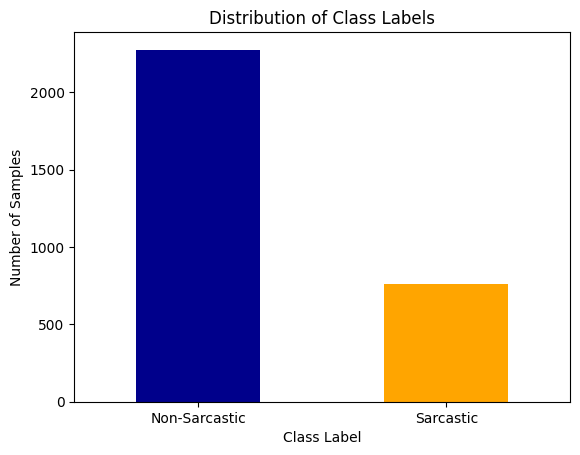

In [14]:
# Count the number of occurrences of each class
label_counts = train['label'].value_counts()

# Create a bar plot
label_counts.plot(kind='bar')

# Create a bar plot with specified colors
colors = ['darkblue', 'orange']  # Class 0 in blue, Class 1 in orange
label_counts.plot(kind='bar', color=colors)

plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Distribution of Class Labels')
plt.xticks([0, 1], ['Non-Sarcastic', 'Sarcastic'], rotation=0)  # Set the x-ticks to be class labels
plt.show()

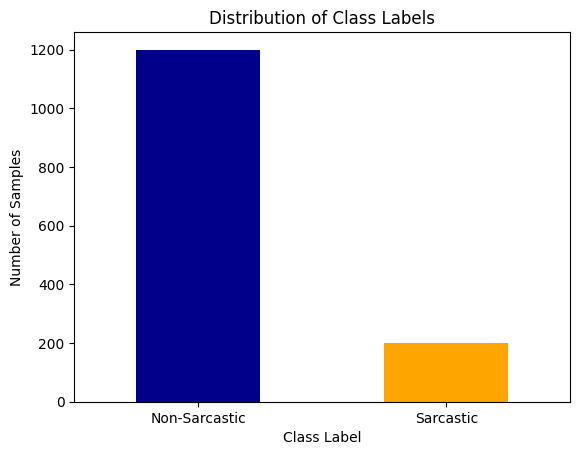

In [15]:
# Count the number of occurrences of each class
label_counts = data_test['label'].value_counts()

# Create a bar plot
label_counts.plot(kind='bar')

# Create a bar plot with specified colors
colors = ['darkblue', 'orange']  # Class 0 in blue, Class 1 in orange
label_counts.plot(kind='bar', color=colors)

plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Distribution of Class Labels')
plt.xticks([0, 1], ['Non-Sarcastic', 'Sarcastic'], rotation=0)  # Set the x-ticks to be class labels
plt.show()

33


(0.0, 300.0)

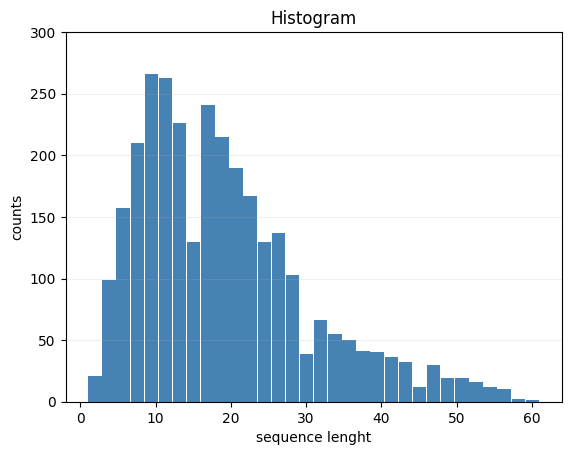

In [16]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train['sentence']]

n, bins, patches = plt.hist(seq_len, bins='auto', color='steelblue',
                            alpha=1, rwidth=0.95)
print(len(bins))
plt.grid(axis='y', alpha=0.2)
plt.xlabel('sequence lenght')
plt.ylabel('counts')
plt.title('Histogram')

maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 9) * 10 if maxfreq % 10 else maxfreq + 10)

## <h2><font color='orchid'>1.4 Split the dataset

In [17]:
train = train.sample(frac=1)

In [18]:
# Assuming 'label' is the column name containing the labels
label_count = train['label'].value_counts()

# Calculate the percentage of label '1'
if 1 in label_count:
    percentage = (label_count[1] / len(data_train)) * 100
else:
    percentage = 0

print(f"Percentage of label '1' in the dataset: {percentage}%")

Percentage of label '1' in the dataset: 21.885813148788927%


In [19]:
# Assuming 'label' is the column name containing the labels
label_count = validate['label'].value_counts()

# Calculate the percentage of label '1'
if 1 in label_count:
    percentage = (label_count[1] / len(validate)) * 100
else:
    percentage = 0

print(f"Percentage of label '1' in the dataset: {percentage}%")

Percentage of label '1' in the dataset: 25.0%


## <h2><font color='orchid'>1.5 Encoding data

In [20]:
# train dataset
# train dataset
from transformers import BertTokenizer , DistilBertTokenizer, RobertaTokenizer , ElectraTokenizer , AlbertTokenizer,  AutoTokenizer
"""google/electra-base-discriminator"""
"""google/electra-large-discriminator"""

"""
Tokenizers:
BERT: BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
Electra: ElectraTokenizer.from_pretrained('google/electra-large-discriminator', do_lower_case=True)

vinai/bertweet-large
microsoft/deberta-v3-large
"""


# For transformers v4.x+:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large", use_fast=False)

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
# tokenizer = RobertaTokenizer.from_pretrained('roberta-large', do_lower_case=True)
# tokenizer = ElectraTokenizer.from_pretrained('google/electra-large-discriminator', do_lower_case=True)

# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased" , do_lower_case=True)

max_sequence_length = 40

# train_data_encoded = DataLoader(encode_examples(train_dataset, max_sequence_length) , batch_size = batch_size)
# validation_data_encoded = DataLoader(encode_examples(validation_dataset , max_sequence_length) , batch_size= batch_size)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [21]:
import transformers
transformers.logging.set_verbosity_error() # prevent from warning message

train_encode = tokenizer(train['sentence'].tolist(),
                         max_length = max_sequence_length,
                         padding="max_length",truncation=True)
validation_encode = tokenizer(validate['sentence'].tolist(),
                               max_length = max_sequence_length,
                               padding="max_length",truncation=True)
test_encode = tokenizer(data_test['sentence'].tolist(),
                        max_length = max_sequence_length,
                        padding="max_length",truncation=True)


In [22]:
train_seq = torch.tensor(train_encode['input_ids'])
train_mask = torch.tensor(train_encode['attention_mask'])
train_y = torch.tensor(train['label'].tolist())

valid_seq = torch.tensor(validation_encode['input_ids'])
valid_mask = torch.tensor(validation_encode['attention_mask'])
valid_y = torch.tensor(validate['label'].tolist())

In [23]:
train_tensors = TensorDataset(train_seq, train_mask, train_y)
validation_tensors = TensorDataset(valid_seq, valid_mask, valid_y)

## <h2><font color='orchid'>1.6 Batch Size and Max Lenght

In [24]:
batch_size = 16
max_sequence_length = 40

train_data_encoded = DataLoader(train_tensors , batch_size = batch_size)
validation_data_encoded = DataLoader(validation_tensors , batch_size= batch_size)

# <h1><font color=darkcyan>Model

## <h2><font color='darkcyan'>2.1 Defining Model

In [25]:
from transformers import AutoModel, BertModel , DistilBertModel, RobertaModel , XLNetModel , ElectraModel , DebertaModel , AlbertModel

from torch import nn
"""
DistilBertModel
BertModel
google/electra-base-discriminator
google/electra-large-discriminator

deberta-base
albert-xxlarge-v1
microsoft/deberta-v3-large
FacebookAI/roberta-large
"""

Bert = AutoModel.from_pretrained("microsoft/deberta-v3-large")

model_name = "bert-large-uncased"

# model_name = "roberta-large"
# Bert = BertModel.from_pretrained(model_name)

# Bert = RobertaModel.from_pretrained('roberta-large')

In [26]:
class Representation_Model(nn.Module):
    def __init__(self, dropout_rate=0.2):
          super(Representation_Model, self).__init__()
          self.bert = Bert
          if model_name == "bert-base-uncased":
             input_size = 768
          elif model_name == "bert-large-uncased":
             input_size = 1024
          else:
             input_size = 1024

          self.sigmoid = nn.Sigmoid()
          self.fc1 = nn.Linear(input_size, 512)
          self.relu = nn.ReLU()  # ReLU activation layer
          self.fc2 = nn.Linear(512, 1)
          self.dropout = nn.Dropout(dropout_rate)  # Dropout layer

    def forward(self, ids, mask , return_embeddings=False, return_all_hidden = False):

          discriminator_hidden_states = self.bert(
               input_ids = ids,
               attention_mask = mask)

          CLS_embedding = discriminator_hidden_states[0][:,0,:]

          # output_rep = self.fc1(CLS_embedding)
          # output_rep = self.relu(output_rep)  # Apply ReLU after fc1
          # output_rep = self.fc2(output_rep)
          # output_rep = self.dropout(output_rep)
          output = self.fc1(CLS_embedding)
          output = self.dropout(output)
          # output = self.relu(output)
          output = self.fc2(output)
          match_score = self.sigmoid(output)

          # if return_embeddings == True:


          if return_all_hidden == True:
             toke_embeddings = discriminator_hidden_states.last_hidden_state
             return toke_embeddings

          return match_score , CLS_embedding

In [27]:
embedding_model = Representation_Model()

## <h2><font color='darkcyan'>2.2 Names and Dimensions of layers
The embedding layer,The first of the twelve transformers & The output layer.

In [28]:
# Get all of the model's parameters as a list of tuples.
params = list(embedding_model.named_parameters())
print('The  model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The  model has 394 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (128100, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)
bert.encoder.layer.0.attention.self.query_proj.weight   (1024, 1024)
bert.encoder.layer.0.attention.self.query_proj.bias          (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.key_proj.weight     (1024, 1024)
bert.encoder.layer.0.attention.self.key_proj.bias            (1024,)
bert.encoder.layer.0.attention.self.value_proj.weight   (1024, 1024)
bert.encoder.layer.0.attention.self.value_proj.bias          (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             (1024,)
bert.encoder.layer.0.attention.output.LayerNorm.weight       (1024,)
bert.encoder.layer.0.attention.output.LayerNorm.bias         (102

In [29]:
# Tell pytorch to run this model on the GPU.
device = 'cuda'
embedding_model.to(device)

Representation_Model(
  (bert): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)

# <h1><font color='darkgreen'>Training

### <h2><font color='darkgreen'>3.1 Function to calculate the accuracy

In [30]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):

    pred_flat = []
    for n in preds:
        if n > 0.5:
          pred_flat.append(1)
        else:
          pred_flat.append(0)

    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

### <h2><font color='darkgreen'>3.2 Helper function for formatting elapsed times.


In [31]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## <h2><font color='darkgreen'>3.3 HyperParameters

In [32]:
import torch
import torch.nn.functional as F

def binary_focal_SupConLoss(features, labels, gamma=2, temp=0.07):
    """
    Adaptation of asy_focal_SupConLoss for binary classification with sigmoid outputs.

    Args:
    - features: Tensor of shape (batch_size, feature_dim), model embeddings.
    - labels: Tensor of shape (batch_size,), binary class labels.
    - gamma: Focusing parameter for Focal Loss.
    - temp: Temperature scaling applied to contrastive loss component.

    Returns:
    - loss: Computed loss as a scalar tensor.
    """
    device = features.device
    batch_size = features.shape[0]

    # Ensure labels are in the correct shape
    labels = labels.view(-1, 1)

    # Create mask based on binary labels
    mask = torch.eq(labels, labels.T).float().to(device)

    # Normalize features to unit length
    normalized_features = F.normalize(features, p=2, dim=1)

    # Compute similarity matrix
    similarity_matrix = torch.matmul(normalized_features, normalized_features.T) / temp

    # Apply mask to select positive similarities
    positives = similarity_matrix * mask

    # Apply log sum exp trick for numerical stability
    max_val = torch.max(positives, dim=1, keepdim=True)[0]
    positives = positives - max_val.detach()

    # Calculate log-probabilities
    log_probs = positives - torch.log(torch.exp(positives).sum(dim=1, keepdim=True))

    # Calculate focal loss component
    probs = torch.exp(log_probs)
    focal_weight = (1 - probs) ** gamma
    focal_loss = -focal_weight * log_probs

    # Compute final loss as mean of focal loss
    loss = focal_loss.mean()

    return loss


In [33]:
# test dataset
batch_size = 200
max_sequence_length = 40

test_seq = torch.tensor(test_encode['input_ids'])
test_mask = torch.tensor(test_encode['attention_mask'])
test_y = torch.tensor(data_test['label'].tolist())
test_tensors = TensorDataset(test_seq, test_mask, test_y)

test_data_encoded = DataLoader(test_tensors , batch_size = batch_size)
# combined_data_encoded = DataLoader(encode_examples(compined_dataset, max_sequence_length) , batch_size = batch_size)

In [34]:
loss_fn = torch.nn.BCELoss()
# loss_fn = FocalLoss()
# criterion = asy_focal_SupConLoss()

epochs = 5
lam = 0.9

from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(embedding_model.parameters(),
                  lr = 1e-5, # default is 5e-5
                  eps = 1e-8, #  default is 1e-8.
                )

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_data_encoded) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 20,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
max_f1_positive = 0

## <h2><font color='darkgreen'>3.4 Start Training

### <h3><font color='darkgreen'> Stage 1

In [36]:
import sys
# Store the average loss after each epoch so we can plot them.
loss_values  = []

total_loss = 0
train_list = []

for i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(i + 1, epochs))


    n_epoch = i + 1
    print(
        f"{'Epoch':^8} | {'Batch':^8} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val F1 Positive':^10} | {'Elapsed':^9}")
    print("-" * 92)

    # Measure the elapsed time of each epoch
    t0_epoch, t0_batch = time.time(), time.time()

    # Reset tracking variables at the beginning of each epoch
    total_loss, batch_loss, batch_counts = 0, 0, 0

    embedding_model.train()

    train_accuracy = []

    for i_batch, batch in enumerate(train_data_encoded):

        embedding_model.zero_grad()  # Zero gradients at the start of batch processing
        batch_counts += 1


        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        logits , hidden_state = embedding_model.forward(ids=input_ids, mask=attention_mask)


        # loss value out of the tuple.

        # loss = None
        # loss_fct = criterion
        # labels = labels.float()
        # loss = loss_fct(logits, labels)
        logits = torch.flatten(logits)
        labels = labels.float()
        cross_loss = loss_fn(logits, labels)
        contrastive_l = binary_focal_SupConLoss(hidden_state, labels)

        loss = (lam * contrastive_l) + (1 - lam) * (cross_loss)


        # from the tensor.
        batch_loss += loss.item()
        total_loss += loss.item()
        print(
            f"\r{n_epoch:^8} | {i_batch:^8} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {'-':^9.2} | {'-':^9.2} " , end='')

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(embedding_model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        scheduler.step()

        # Update the learning rate.

        embedding_model.zero_grad()


    # Calculate the average loss over the entire training data
    avg_train_loss = total_loss / len(train_data_encoded)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

        # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    embedding_model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = 0
    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    batch_counts_eval = 0

    total_preds = []
    # Evaluate data for one epoch
    for batch in validation_data_encoded:

        batch_counts_eval += 1

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask , b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            logits , hidden_state = embedding_model.forward(ids=b_input_ids,
                            mask=b_input_mask)

        b_labels = b_labels.float()
        logits = torch.flatten(logits)
        cross_loss = loss_fn(logits, b_labels)
        contrastive_l = binary_focal_SupConLoss(hidden_state, b_labels)
        loss = (lam * contrastive_l) + (1 - lam) * (cross_loss)


        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Get the predictions
        preds = []
        for n in logits:
            preds.append(1.0 if n > 0.5 else 0.0)

        total_preds.extend(preds)



        val_loss += loss.item()

        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch

        nb_eval_steps += 1

        # Calculate F1 score using sklearn

    # Compute the average accuracy and loss over the validation set.
    # print('val loss before mean:', val_loss)
    # val_loss = np.mean(val_loss)

    val_loss = val_loss / len(test_data_encoded)

    total_labels = validate['label'].tolist()

    f1_scores = f1_score(total_labels, total_preds, average=None)

    f1_positive_class = f1_scores[1]


    # val_accuracy = np.mean(val_accuracy)
    # print('val loss before mean:', val_loss)

    # Update scheduler with validation loss

    if f1_positive_class > max_f1_positive:
        max_f1_positive = f1_positive_class
        # Save the model
        torch.save({
            'epoch': n_epoch,
            'model_state_dict': embedding_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'f1_positive_class': f1_positive_class,
            }, 'model_checkpoint.pth')



    # f1 = f1_score(b_labels.cpu().numpy(), preds.cpu().numpy(), average='macro')
    print("-" * 92)
    print(
        f"{'end':^8} | {'-':^8} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {f1_positive_class:^9.2f} | {time_elapsed:^9.2f}")
    print("-" * 92)
    print("\n")
print("")
print("Training complete!")


======== Epoch 1 / 5 ========
 Epoch   |  Batch   |  Train Loss  |  Val Loss  | Val F1 Positive |  Elapsed 
--------------------------------------------------------------------------------------------
   1     |   189    |   6.146417   |     -      |     -     |     -     |     -     --------------------------------------------------------------------------------------------
  end    |    -     |   6.146417   | 24.603043  |   0.00    |   61.98  
--------------------------------------------------------------------------------------------



======== Epoch 2 / 5 ========
 Epoch   |  Batch   |  Train Loss  |  Val Loss  | Val F1 Positive |  Elapsed 
--------------------------------------------------------------------------------------------
   2     |   189    |   6.133933   |     -      |     -     |     -     |     -     --------------------------------------------------------------------------------------------
  end    |    -     |   6.133933   | 24.576376  |   0.00    |   45.38  
---

In [37]:
# Load the weights from the saved file
model_weights = torch.load("/content/model_checkpoint.pth")

model_weights = model_weights['model_state_dict']
# Load the weights into your model
embedding_model.load_state_dict(model_weights)

<All keys matched successfully>

## TSNE

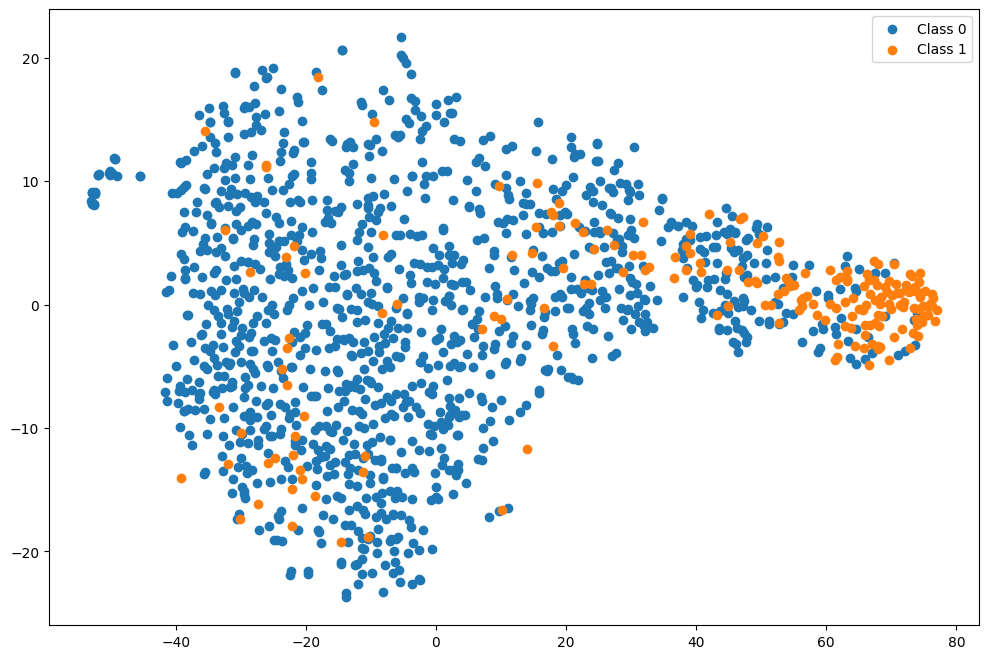

In [38]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming embedding_model is your trained model
# and train_data_encoded is your dataset

embeddings = []
labels = []

embedding_model.eval()
with torch.no_grad():
    for batch in test_data_encoded:
        input_ids, attention_mask, batch_labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        logits , batch_embeddings = embedding_model.forward(input_ids, attention_mask, return_embeddings = True)
        embeddings.append(batch_embeddings.cpu().numpy())
        labels.append(batch_labels.cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(12,8))
for i in np.unique(labels):
    indices = labels == i
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=f'Class {i}')
plt.legend()
plt.show()


### <h3><font color='darkgreen'> Stage 2

## <h2><font color='darkgreen'>3.5 Learn Threshold

In [39]:
def inference_match_score(model , tensor_data , dataframe ):

# Stance should be true if we want to organize the scores based on the stance of the arguments towards the topic
    print('Predicting Match score for {:,} test sentences...'.format(len(tensor_data)))
    # Put model in evaluation mode
    model.eval()
    # Tracking variables
    match_scores = []
    # Predict
    count = 0
    for sample in tensor_data:
      count += 1



      # Add batch to GPU
      sample = tuple(t.to('cuda') for t in sample)

      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = sample

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          logits , _  = model.forward(ids=b_input_ids,
                          mask=b_input_mask)
          logits = torch.flatten(logits)
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      # Store predictions
      match_scores.append(logits)
      sys.stdout.write(f'\rPredicted {count}/{len(tensor_data)} ')
      sys.stdout.flush()

    match_scores = [l.tolist() for l in match_scores]
    match_scores = [x for xs in match_scores for x in xs]

    print('DONE.')
    return match_scores


# <h1><font color='lightcoral'>Match Scoring

In [40]:
# test dataset
batch_size = 200
max_sequence_length = 50

test_seq = torch.tensor(test_encode['input_ids'])
test_mask = torch.tensor(test_encode['attention_mask'])
test_y = torch.tensor(data_test['label'].tolist())
test_tensors = TensorDataset(test_seq, test_mask, test_y)

test_data_encoded = DataLoader(test_tensors , batch_size = batch_size)
# combined_data_encoded = DataLoader(encode_examples(compined_dataset, max_sequence_length) , batch_size = batch_size)

In [41]:
scores = inference_match_score(model = embedding_model , tensor_data = test_data_encoded , dataframe = data_test )


Predicting Match score for 7 test sentences...
Predicted 7/7 DONE.


In [42]:
from sklearn.metrics import average_precision_score

In [43]:
def match_selection(scores , threshold):
    predictions = []
    for s in scores:
        if s > threshold:
          predictions.append(1)
        else:
          predictions.append(0)
    return predictions

In [44]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

In [45]:
labels = data_test['label'].tolist()
pred_flat = match_selection(scores = scores  , threshold = 0.5)

print(' Accuracy: ', sum(1 for x,y in zip(pred_flat,labels) if x == y) / len(pred_flat))
P_R_F1 = precision_recall_fscore_support(y_true = labels, y_pred = pred_flat, average='binary')
print(f' Precision: {P_R_F1[0]}\n Recall:    {P_R_F1[1]}\n F1-score:  {P_R_F1[2]}')

 Accuracy:  0.8721428571428571
 Precision: 0.5466666666666666
 Recall:    0.615
 F1-score:  0.5788235294117647


In [46]:
average_precision_score(y_true = labels, y_score = scores)

0.5368991263966161

In [47]:
print(classification_report(y_true = labels, y_pred = pred_flat , digits=4))

              precision    recall  f1-score   support

           0     0.9345    0.9150    0.9246      1200
           1     0.5467    0.6150    0.5788       200

    accuracy                         0.8721      1400
   macro avg     0.7406    0.7650    0.7517      1400
weighted avg     0.8791    0.8721    0.8752      1400



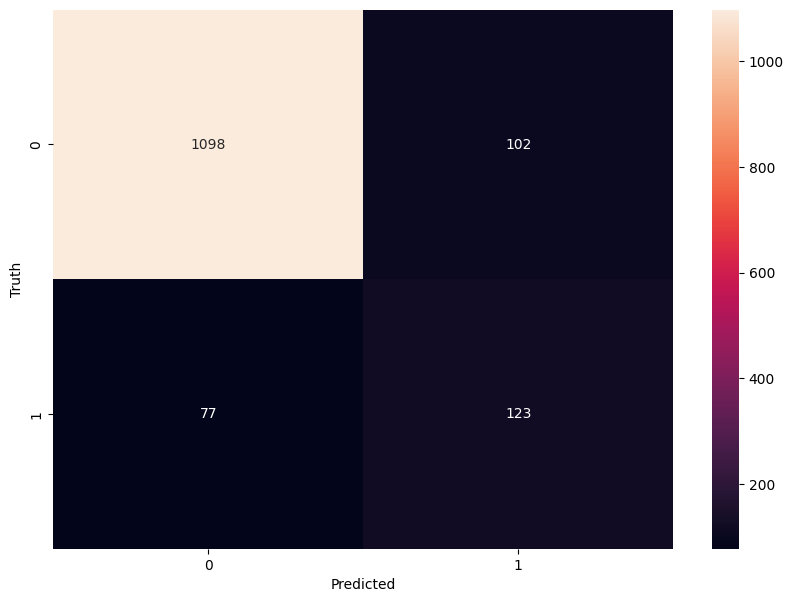

In [48]:
import seaborn as sns

cm = confusion_matrix(labels, pred_flat)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=random_state)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

n_classes = 2

converted_array = np.array([[1, 0] if x == 0 else [0, 1] for x in labels])
converted_scores = np.array([[1 - x, x] for x in scores])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(converted_array[:, i], converted_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(converted_array.ravel(), converted_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


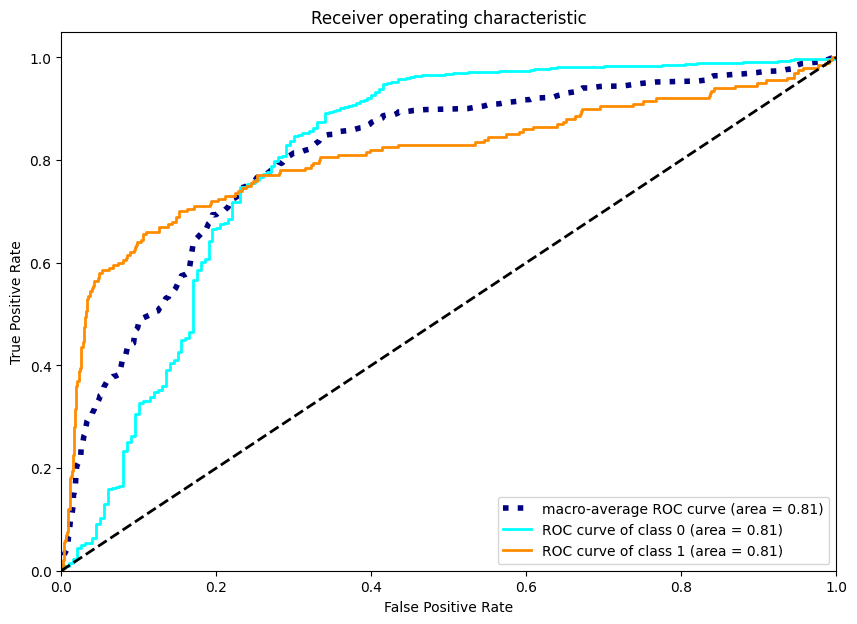

In [51]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,7))


plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [52]:
from sklearn.metrics import roc_curve
import numpy as np

# true_labels and predictions as defined earlier
fpr, tpr, thresholds = roc_curve(labels, pred_flat)

# Youden's J statistic to find the optimal threshold
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

print("Optimal Threshold:", optimal_threshold)


Optimal Threshold: 1


In [53]:
def predict(trained_model, dataset, sample_index):

    trained_model.eval()

    sentence = dataset['sentence'].tolist()[sample_index]

    sample_encode = tokenizer(sentence,
                         max_length = max_sequence_length,
                         padding="max_length",truncation=True)

    train_seq = torch.tensor(sample_encode['input_ids']).to(device).view(1, 50)
    train_mask = torch.tensor(sample_encode['attention_mask']).to(device).view(1, 50)
    train_y = dataset['label'].tolist()[sample_index]


    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        logits , _= trained_model.forward(ids=train_seq,
                        mask=train_mask)

    # Determine the output prediction based on the logits

    prediction = 1 if logits > 0.5 else 0

    print('-'*75)
    print(f"{'Sentence':<15}: {sentence} \n")

    prediction_text = 'Sarcastic' if prediction == 1 else 'Non-sarcastic'
    confidence_text = f"{round(logits[0][0].cpu().item(), 2):<15}" if prediction == 1 else (1 - logits[0][0].cpu().item())
    print(f"{'Prediction':<15}: {prediction_text:<15} {'Confidence':<15}: {confidence_text}")

    ground_truth_text = 'Sarcastic' if train_y == 1 else 'Non-sarcastic'
    print(f"{'Ground Truth':<15}: {ground_truth_text}")
    print('-'*75)




# Note: This is a general template. The actual implementation of preprocess and predict methods
# will depend on the specifics of the trained_model and its underlying framework (e.g., TensorFlow, PyTorch).


In [54]:
predict(trained_model = embedding_model,
        dataset = data_test,
        sample_index = 2)

---------------------------------------------------------------------------
Sentence       : So the Scottish Government want people to get their booster shots so badly that the website doesn't even work 

Prediction     : Sarcastic       Confidence     : 0.84           
Ground Truth   : Sarcastic
---------------------------------------------------------------------------


In [55]:
!pip install shap

In [56]:
class ModifiedModel(nn.Module):
    def __init__(self, original_model):
        super(ModifiedModel, self).__init__()
        self.original_model = original_model

    def forward(self, train_seq , train_mask):

        # train_encode = tokenizer(text,
        #                  max_length = 40,
        #                  padding="max_length",truncation=True)
        # train_seq = torch.tensor(train_encode['input_ids']).cuda()
        # train_mask = torch.tensor(train_encode['attention_mask']).cuda()


        # Call the original model
        logits, _ = self.original_model.forward(ids=train_seq, mask=train_mask)


        # Apply sigmoid to the logits to get the positive score
        positive_scores = torch.sigmoid(logits)

        # Calculate the negative scores
        negative_scores = 1 - positive_scores

        # Concatenate negative and positive scores side by side
        # Since positive_scores and negative_scores are already in the desired format ([batch_size, 1]),
        # we concatenate them along dim=1 to get a [batch_size, 2] tensor
        outputs = torch.cat((negative_scores, positive_scores), dim=1)

        return outputs



# Assuming embedding_model is your original PyTorch model
# Wrap your original model with ModifiedModel
modified_model = ModifiedModel(embedding_model)

In [57]:
data_test['sentence'].tolist()[2]

"So the Scottish Government want people to get their booster shots so badly that the website doesn't even work"

In [58]:
import scipy as sp

In [59]:
# this defines an explicit python function that takes a list of strings and outputs scores for each class
def f(x):
    tv = torch.tensor(
        [
            tokenizer.encode(v, padding="max_length", max_length=40, truncation=True)
            for v in x
        ]
    ).cuda()
    attention_mask = (tv != 0).type(torch.int64).cuda()
    outputs = modified_model(tv, train_mask=attention_mask).detach().cpu().numpy()

    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

In [60]:
labels = ['Normal', 'Sarcastic']

In [61]:
import shap

In [62]:
method = "transformers tokenizer"

# build an explainer by passing a transformers tokenizer
if method == "transformers tokenizer":
    explainer = shap.Explainer(f, tokenizer, output_names=labels)

# build an explainer by explicitly creating a masker
elif method == "default masker":
    masker = shap.maskers.Text(r"\W")  # this will create a basic whitespace tokenizer
    explainer = shap.Explainer(f, masker, output_names=labels)

# build a fully custom tokenizer
elif method == "custom tokenizer":
    import re

    def custom_tokenizer(s, return_offsets_mapping=True):
        """Custom tokenizers conform to a subset of the transformers API."""
        pos = 0
        offset_ranges = []
        input_ids = []
        for m in re.finditer(r"\W", s):
            start, end = m.span(0)
            offset_ranges.append((pos, start))
            input_ids.append(s[pos:start])
            pos = end
        if pos != len(s):
            offset_ranges.append((pos, len(s)))
            input_ids.append(s[pos:])
        out = {}
        out["input_ids"] = input_ids
        if return_offsets_mapping:
            out["offset_mapping"] = offset_ranges
        return out

    masker = shap.maskers.Text(custom_tokenizer)
    explainer = shap.Explainer(f, masker, output_names=labels)

In [63]:
predict(trained_model = embedding_model,
        dataset = data_test,
        sample_index = 1323)

---------------------------------------------------------------------------
Sentence       : Love it when you clearly make a restaurant aware of dietary conditions and they ignore it :smiling_face_with_tear: 

Prediction     : Sarcastic       Confidence     : 0.88           
Ground Truth   : Sarcastic
---------------------------------------------------------------------------


In [64]:
shap_values = explainer([data_test['sentence'].tolist()[1323]])


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.21s/it]               


In [65]:
shap.plots.text(shap_values[0, :, "Sarcastic"])


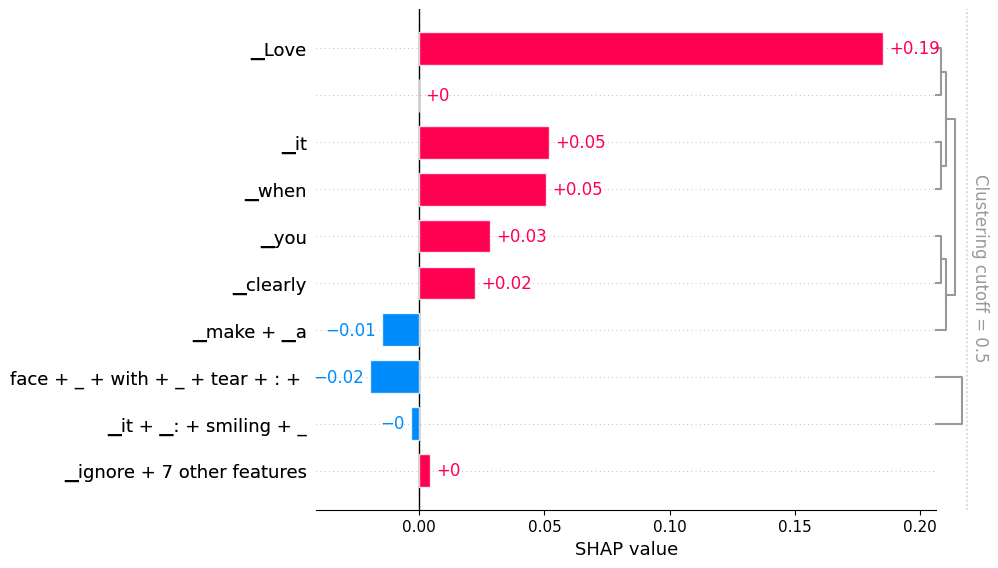

In [66]:
shap.plots.bar(shap_values[0, :, "Sarcastic"])
